In [1]:
import copy
import random

import cv2

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms

from sklearn.metrics import accuracy_score
from sklearn.datasets import fetch_olivetti_faces

In [2]:
# !pip install git+https://github.com/Koukyosyumei/secure_ml

  Cloning https://github.com/Koukyosyumei/secure_ml to /tmp/pip-req-build-5_8tdtx8
  Running command git clone -q https://github.com/Koukyosyumei/secure_ml /tmp/pip-req-build-5_8tdtx8
  Created wheel for secureml: filename=secureml-0.0.0-py3-none-any.whl size=26600 sha256=fba7ed6ee6eca4979f23b49a855fe19a080fdc2a629dce0b9b9f638d4a89d022
  Stored in directory: /tmp/pip-ephem-wheel-cache-60nupqh1/wheels/78/e1/bc/5a517b94b9e9f5abaea9450393b7d728090413f0e7bb7c01a9
Successfully built secureml


In [4]:
from secureml.collaborative import Client, Server
from secureml.attack import GAN_Attack_Client
from secureml.utils import DataSet

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 5),
            nn.Tanh(),
            nn.MaxPool2d(3, 3, 1),
            nn.Conv2d(32, 64, 5),
            nn.Tanh(),
            nn.MaxPool2d(3, 3, 1)
        )
        
        self.lin = nn.Sequential(
            nn.Linear(256, 200),
            nn.Tanh(),
            nn.Linear(200, 11),
            nn.LogSoftmax()            
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.reshape((-1, 256))
        x = self.lin(x)
        return x

In [6]:
# Generator Code (from https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html)

class Generator(nn.Module):
    def __init__(self, nz, nc, ngf):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 4, 4, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 3, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 2, ngf * 1, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 1),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 1, 1, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [8]:
# Number of channels in the training images. For color images this is 3
nc = 1
# Size of z latent vector (i.e. size of generator input)
nz = 100
# Size of feature maps in generator
ngf = 64
# Batch Size
batch_size = 64

In [7]:
device = torch.device('cuda:0') if torch.cuda.is_available() else "cpu"
print(device)

cuda:0


In [9]:
at_t_dataset_train = torchvision.datasets.MNIST(root="./", train=True, download=True)
at_t_dataset_test = torchvision.datasets.MNIST(root="./", train=False, download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [10]:
X = at_t_dataset_train.data.numpy()
y = at_t_dataset_train.targets.numpy()

# ToTensor：画像のグレースケール化（RGBの0~255を0~1の範囲に正規化）、Normalize：Z値化（RGBの平均と標準偏差を0.5で決め打ちして正規化）
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, ), (0.5, ))])

#idx_1 = random.sample(range(400), 200)
#idx_2 = list(set(range(400)) - set(idx_1))
idx_1 = np.where(y<5)[0]
idx_2 = np.where(y>=5)[0]

global_trainset = DataSet(at_t_dataset_test.data.numpy(), at_t_dataset_test.targets.numpy(), transform=transform)
global_trainloader = torch.utils.data.DataLoader(global_trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
trainset_1 = DataSet(X[idx_1], y[idx_1], transform=transform)
trainloader_1 = torch.utils.data.DataLoader(trainset_1, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
trainset_2 = DataSet(X[idx_2], y[idx_2], transform=transform)
trainloader_2 = torch.utils.data.DataLoader(trainset_2, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

trainloaders = [trainloader_1, trainloader_2]
dataset_nums = [200, 200]

In [11]:
criterion = nn.CrossEntropyLoss()
client_num = 2
adversary_client_id = 1
target_label = 0

In [13]:
net_1 = Net()
client_1 = Client(net_1, user_id=0)
client_1.to(device)
optimizer_1 = optim.SGD(client_1.parameters(), lr=0.02, weight_decay=1e-7, momentum=0.9)

net_2 = Net()
generator = Generator(nz, nc, ngf)
generator.to(device)
optimizer_g = optim.SGD(generator.parameters(), lr=0.05, weight_decay=1e-7, momentum=0.0)
client_2 = GAN_Attack_Client(net_2, target_label, generator,
                             optimizer_g, criterion, user_id=1, nz=nz, device=device)
client_2.to(device)
optimizer_2 = optim.SGD(client_2.parameters(), lr=0.02, weight_decay=1e-7, momentum=0.9)

clients = [client_1, client_2]
optimizers = [optimizer_1, optimizer_2]

global_model = Net()
global_model.to(device)
server = Server(clients, global_model)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


epoch-0: client-1 0.3523813873770996
epoch-0: client-2 0.4517160916107241
epoch 0: generator loss is 0.03236690453892094
epoch 0: accuracy is  0.7164
reconstrunction error is  1.1642127558376276
epoch-1: client-1 0.11859029644154362
epoch-1: client-2 0.13541388629062567
epoch 0: generator loss is 0.009530061124384995
epoch 1: accuracy is  0.8857
reconstrunction error is  1.1661107533322064
epoch-2: client-1 0.05641658808475768
epoch-2: client-2 0.06730907856021076
epoch 0: generator loss is 0.0004558641064560887
epoch 2: accuracy is  0.9434
reconstrunction error is  1.165995773629999
epoch-3: client-1 0.058258644710294905
epoch-3: client-2 0.06312964270822703
epoch 0: generator loss is 0.0003877246275761066
epoch 3: accuracy is  0.9113
reconstrunction error is  1.1668525296260424
epoch-4: client-1 0.03563900499386364
epoch-4: client-2 0.04124388349999208
epoch 0: generator loss is 0.00323956014281624
epoch 4: accuracy is  0.9612
reconstrunction error is  1.1680232809570008
epoch-5: cli

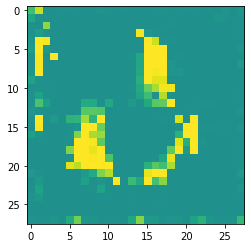

In [14]:
fake_batch_size = batch_size
fake_label = 10

for epoch in range(10): 
    for client_idx in range(client_num):
        client = clients[client_idx]
        trainloader = trainloaders[client_idx]
        optimizer = optimizers[client_idx]

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            if epoch != 0:
              fake_image = client_2.attack(fake_batch_size)
              inputs = torch.concat([inputs, fake_image])
              labels = torch.concat([labels, torch.tensor([fake_label]*fake_batch_size, device=device)])


            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = client(inputs)
            loss = criterion(outputs, labels.to(torch.int64))
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"epoch epoch}: client-{client_idx+1}",
              running_loss / dataset_nums[client_idx])
        
        if client_idx == adversary_client_id:
            client.update_generator(trainloader, epoch=5)
    
    server.update()
    server.distribtue()

    in_preds = []
    in_label = []
    with torch.no_grad():
            for data in global_trainloader:
                inputs, labels = data
                inputs = inputs.to(device)
                outputs = server.global_model(inputs)
                in_preds.append(outputs)
                in_label.append(labels)  
            in_preds = torch.cat(in_preds)
            in_label = torch.cat(in_label)
    print(f"epoch {epoch}: accuracy is ", accuracy_score(np.array(torch.argmax(in_preds, axis=1).cpu()),
                        np.array(in_label)))
    
    reconstructed_image = client_2.attack(1).cpu().numpy().reshape(28, 28)
    print("reconstrunction error is ", np.sqrt(np.sum(((X[np.where(y==target_label)[0][:10], :, :]-0.5/0.5) - reconstructed_image) ** 2)) / (10*(28*28)))
    plt.imshow(reconstructed_image * 0.5 + 0.5, vmin=-1,vmax=1)
    plt.savefig(f"{epoch}.png")